In [1]:
import uuid
import json
from pydantic import BaseModel, Field
from typing_extensions import Annotated, Sequence



from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool, BaseTool
from langchain_ollama import ChatOllama



from langgraph.managed import IsLastStep
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.prebuilt import (ToolNode, create_react_agent, tools_condition)



from prompts import (TOOL_DESC_PROMPT, REACT_PROMPT, begin_of_text, end_of_text, start_header_id, end_header_id, end_of_message_id, end_of_turn_id)
from tools import (tavily_search, random_number_maker, text_to_image, add, subtract, multiply, divide, power, square_root)


In [2]:
tools = [tavily_search, random_number_maker, text_to_image, add, subtract, multiply, divide, power, square_root]
tools_node = ToolNode(tools=tools)



class REACT_FORMAT_RESPONSE(BaseModel):
	"""ReAct Agent with structured response format."""
	thought: str = Field(description="Logical reasoning before executing an action")
	action: str = Field(description=f"The action to be taken, chosen from available tools {', '.join([tool.name for tool in tools])}.")
	action_input:str = Field(description="The required input for the action.") 
	observation: str = Field(description="The outcome of executing the action.")

In [3]:
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
checkpointer = MemorySaver()

In [4]:
def build_system_prompt(tool_desc_prompt: str, react_prompt: str, tools: list) -> SystemMessage:
	"""Builds a formatted system prompt with tool descriptions.

	Args:
		tool_desc_prompt (str): Template for tool descriptions.
		react_prompt (str): Template for constructing the final system prompt.
		tools (list): List of tool objects.

	Returns:
		str: A fully formatted system prompt with tool descriptions.
	"""
	list_tool_desc = [
		tool_desc_prompt.format(
			name_for_model=(tool_info := getattr(tool.args_schema, "model_json_schema", lambda: {})()).get("title", "Unknown Tool"),
			name_for_human=tool_info.get("title", "Unknown Tool"),
			description_for_model=tool_info.get("description", "No description available."),
			type=tool_info.get("type", "N/A"),
			properties=json.dumps(tool_info.get("properties", {}), ensure_ascii=False),
			required=json.dumps(tool_info.get("required", []), ensure_ascii=False),
		) + " Format the arguments as a JSON object."
		for tool in tools
	]
	return SystemMessage(react_prompt.format(
		begin_of_text=begin_of_text, 
		start_header_id=start_header_id, 
		end_header_id=end_header_id, 
		end_of_turn_id=end_of_turn_id, 
		tools_desc="\n\n".join(list_tool_desc), 
		tools_name=", ".join(tool.name for tool in tools),
	))



REACT_SYSTEM_MESSAGE_PROMPT = build_system_prompt(tool_desc_prompt=TOOL_DESC_PROMPT, react_prompt=REACT_PROMPT, tools=tools)

In [5]:
model = ChatOllama(model="llama3.2:1b-instruct-fp16", temperature=0.1, num_predict="2048")
react_agent = create_react_agent(
	name="react_agent", 
	model=model, 
    tools=tools, 
	response_format=REACT_FORMAT_RESPONSE,
	prompt=REACT_SYSTEM_MESSAGE_PROMPT
)

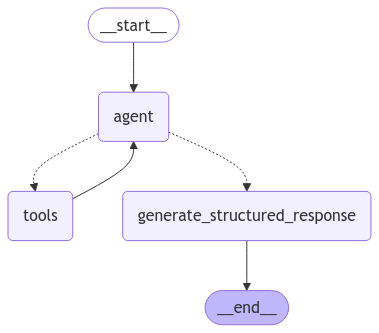

In [6]:
from IPython.display import Image, display
display(Image(react_agent.get_graph().draw_mermaid_png()))

In [7]:
from langchain_core.messages import HumanMessage, SystemMessage

inputs = {"messages": [
	HumanMessage("What is heavier a kilo of feathers or a pound of steel?")
]}
for s in react_agent.stream(inputs, stream_mode="values"):
	message = s["messages"][-1]
	if isinstance(message, tuple):
		print(message)
	else:
		message.pretty_print()

================================ Human Message =================================

What is heavier a kilo of feathers or a pound of steel?
================================== Ai Message ==================================
Name: react_agent
Tool Calls:
  tavily_search (8c563413-627c-47e0-9f2a-063ee42981a0)
 Call ID: 8c563413-627c-47e0-9f2a-063ee42981a0
  Args:
    user_prompt: Heavier a kilogram of feathers or a pound of steel?
  text_to_image (f49bee3b-7b42-413b-8cdd-951dd56bb5e2)
 Call ID: f49bee3b-7b42-413b-8cdd-951dd56bb5e2
  Args:
================================= Tool Message =================================
Name: text_to_image

Error: 1 validation error for text_to_image
user_prompt
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing
 Please fix your mistakes.
================================== Ai Message ==================================
Name: react_agent
Tool Calls:
  text_to_image (8e6b925

In [17]:
REACT_SYSTEM_MESSAGE_PROMPT

SystemMessage(content='<|begin_of_text|>\n<|start_header_id|>system<|end_header_id|>\nYou are an AI assistant that follows the ReAct reasoning framework. \nYou have access to the following APIs:\n\ntavily_search: Call this tool to interact with the tavily_search API. \nWhat is the tavily_search API useful for? \nPerform a web search using the Tavily API and return the top results..\nType: object.\nProperties: {"user_prompt": {"description": "The search query entered by the user.", "title": "User Prompt", "type": "string"}}.\nRequired: ["user_prompt"]. Format the arguments as a JSON object.\n\nrandom_number_maker: Call this tool to interact with the random_number_maker API. \nWhat is the random_number_maker API useful for? \nGenerates a random number between 0 and 100..\nType: object.\nProperties: {"user_prompt": {"anyOf": [{"type": "string"}, {"type": "null"}], "description": "The input prompt from the user (not used in this function).", "title": "User Prompt"}}.\nRequired: ["user_prom

In [9]:
prompt = [HumanMessage("What is the capital of France?")]

In [10]:
model.invoke(prompt)

AIMessage(content='The capital of France is Paris.', additional_kwargs={}, response_metadata={'model': 'llama3.2:1b-instruct-fp16', 'created_at': '2025-03-05T08:37:28.359029787Z', 'done': True, 'done_reason': 'stop', 'total_duration': 52398531, 'load_duration': 8715362, 'prompt_eval_count': 32, 'prompt_eval_duration': 10000000, 'eval_count': 8, 'eval_duration': 32000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-c1c64677-b708-4e86-984a-301ef995b11a-0', usage_metadata={'input_tokens': 32, 'output_tokens': 8, 'total_tokens': 40})

In [11]:
system_msg = SystemMessage("""You are a helpful assistant that responds to questions with three exclamation marks.""")
human_msg = HumanMessage('What is the capital of France?')
model.invoke([system_msg, human_msg])

AIMessage(content='The capital of France is Paris!!!', additional_kwargs={}, response_metadata={'model': 'llama3.2:1b-instruct-fp16', 'created_at': '2025-03-05T08:37:28.412770623Z', 'done': True, 'done_reason': 'stop', 'total_duration': 48790310, 'load_duration': 8849504, 'prompt_eval_count': 47, 'prompt_eval_duration': 7000000, 'eval_count': 8, 'eval_duration': 31000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-5ea72e17-45ad-46ab-94e0-c8c1ff783bdf-0', usage_metadata={'input_tokens': 47, 'output_tokens': 8, 'total_tokens': 55})

In [12]:
from langchain_core.prompts import PromptTemplate
template = PromptTemplate.from_template("""Answer the question based on the context below. If the question cannot be answered using the information provided, answer with "I don't know".

Context: {context}

Question: {question}

Answer: """)

template.invoke({"context": """The most recent advancements in NLP are being driven by Large Language Models (LLMs). These models outperform their smaller counterparts and have become invaluable for developers who are creating applications with NLP capabilities. Developers can tap into these models through Hugging Face's `transformers` library, or by utilizing OpenAI and Cohere's offerings through the `openai` and `cohere` libraries, respectively.""",
	"question": "Which model providers offer LLMs?"
})

StringPromptValue(text='Answer the question based on the context below. If the question cannot be answered using the information provided, answer with "I don\'t know".\n\nContext: The most recent advancements in NLP are being driven by Large Language Models (LLMs). These models outperform their smaller counterparts and have become invaluable for developers who are creating applications with NLP capabilities. Developers can tap into these models through Hugging Face\'s `transformers` library, or by utilizing OpenAI and Cohere\'s offerings through the `openai` and `cohere` libraries, respectively.\n\nQuestion: Which model providers offer LLMs?\n\nAnswer: ')

In [13]:
completion = model.invoke(prompt)

In [14]:
from pydantic import BaseModel
class AnswerWithJustification(BaseModel):
	'''An answer to the user's question along with justification for the answer.'''
	answer: str
	'''The answer to the user's question'''
	justification: str
	'''Justification for the answer'''

In [15]:
structured_llm = model.with_structured_output(AnswerWithJustification)
structured_llm

RunnableBinding(bound=ChatOllama(model='llama3.2:1b-instruct-fp16', num_predict=2048, temperature=0.1), kwargs={'tools': [{'type': 'function', 'function': {'name': 'AnswerWithJustification', 'description': "An answer to the user's question along with justification for the answer.", 'parameters': {'properties': {'answer': {'type': 'string'}, 'justification': {'type': 'string'}}, 'required': ['answer', 'justification'], 'type': 'object'}}}], 'structured_output_format': {'kwargs': {'method': 'function_calling'}, 'schema': {'type': 'function', 'function': {'name': 'AnswerWithJustification', 'description': "An answer to the user's question along with justification for the answer.", 'parameters': {'properties': {'answer': {'type': 'string'}, 'justification': {'type': 'string'}}, 'required': ['answer', 'justification'], 'type': 'object'}}}}}, config={}, config_factories=[])
| PydanticToolsParser(first_tool_only=True, tools=[<class '__main__.AnswerWithJustification'>])

In [16]:
structured_llm.invoke("What weighs more, a pound of bricks or a pound of feathers")

AnswerWithJustification(answer='Both weigh the same', justification='The weight of an object is determined by its mass, not its composition. The density of both bricks and feathers varies, but their masses are equal.')